In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta


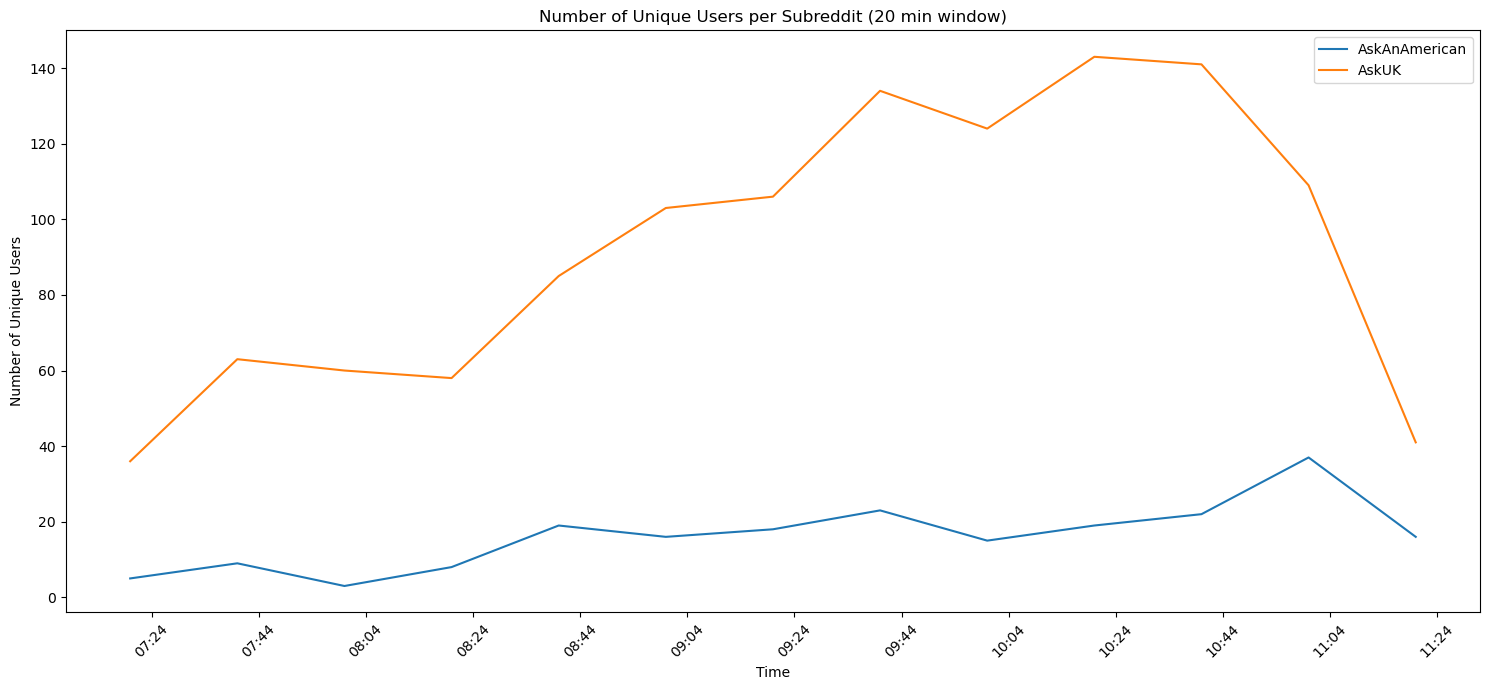

In [42]:
df = pd.read_csv('reddit_data.csv')

# Convert the 'created_utc' column to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Sort the data by the 'created_utc' to ensure that the tumbling window works correctly
df.sort_values('created_utc', inplace=True)

# Set the 'created_utc' column as the index
df.set_index('created_utc', inplace=True)

# Calculate the number of unique users in each subreddit using a tumbling window of 20 minutes.
unique_users_per_subreddit = df.groupby('subreddit')['author'].resample('20T').nunique()
unique_users_per_subreddit = unique_users_per_subreddit.reset_index(name='unique_users')

# Plotting the results
plt.figure(figsize=(15, 7))

# Plot for each subreddit
for subreddit in unique_users_per_subreddit['subreddit'].unique():
    subset = unique_users_per_subreddit[unique_users_per_subreddit['subreddit'] == subreddit]
    plt.plot(subset['created_utc'], subset['unique_users'], label=subreddit)

# Set x-axis major ticks to 20-minute intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=20))

# Format x-tick labels as 'HH:MM'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel('Time')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users per Subreddit (20 min window)')
plt.legend()
plt.xticks(rotation=45) # Rotate the x-axis labels to make them readable
plt.tight_layout() # Adjust the plot to ensure everything fits without overlap
plt.show()

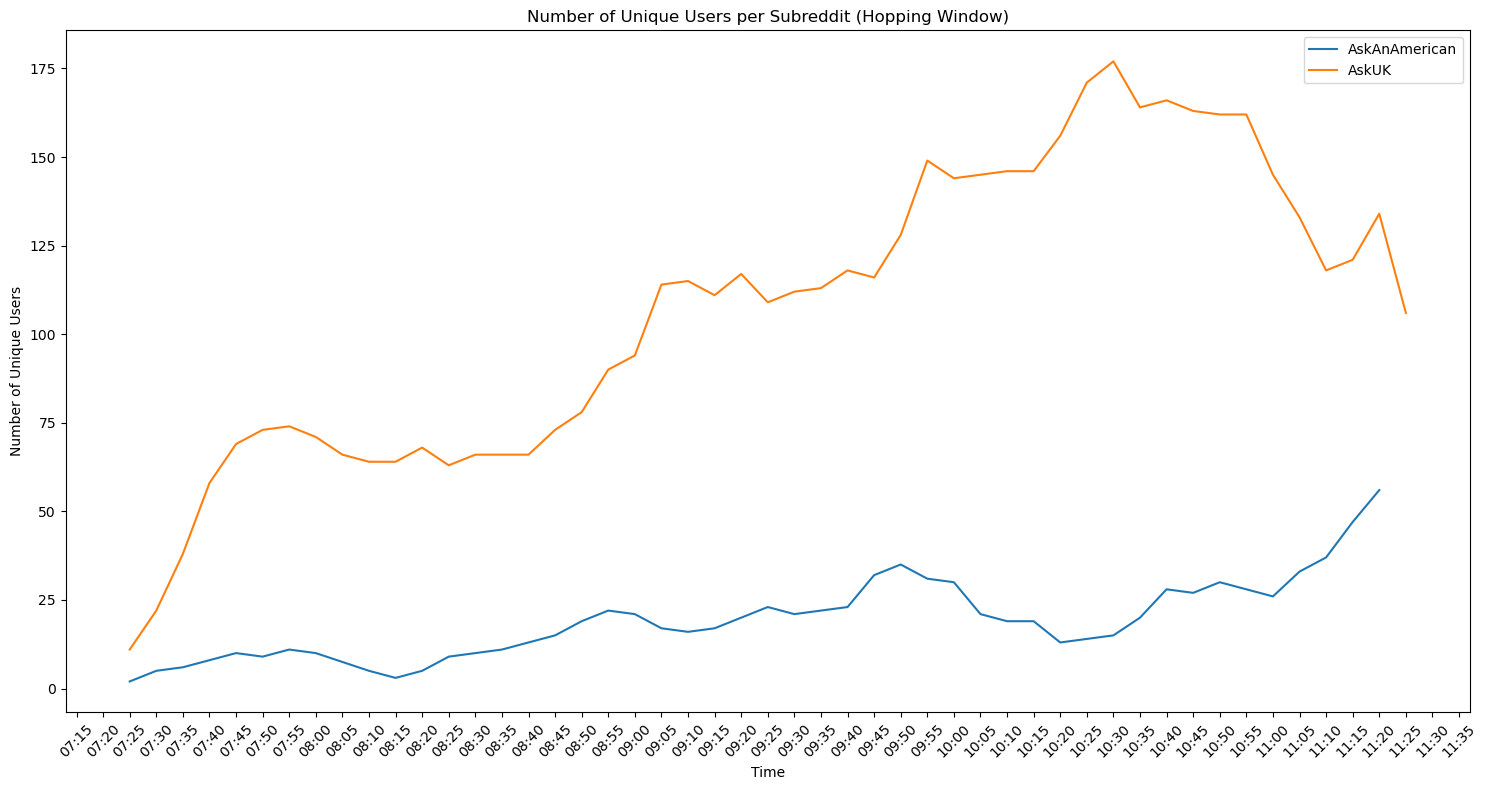

In [43]:
df = pd.read_csv('reddit_data.csv')

# Convert the 'created_utc' column to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define the hopping window parameters
window_length = '20T'  # 20 minutes window length
hop_size = '5T'  # 5 minutes hop size

# Create a new column for the hopping window start times
df['window_start'] = df['created_utc'].dt.floor(freq=hop_size)

# Now calculate the unique users per subreddit per window start
unique_users = (df.groupby(['subreddit', 'window_start'])['author']
                  .nunique()
                  .reset_index(name='unique_users'))

# Now, we need to aggregate these counts within each 20 minute window
# We can do this by changing the index to a datetime and then using `rolling`
unique_users.set_index('window_start', inplace=True)
unique_users.sort_index(inplace=True)

# Apply a rolling window, summing up the unique counts from each 5 minute period to get the 20 minute window count
aggregated_counts = unique_users.groupby('subreddit')['unique_users'].rolling(window_length, min_periods=1).sum()

# Reset the index so we can plot
aggregated_counts = aggregated_counts.reset_index()

# Plotting
plt.figure(figsize=(15, 8))

for subreddit in aggregated_counts['subreddit'].unique():
    subset = aggregated_counts[aggregated_counts['subreddit'] == subreddit]
    plt.plot(subset['window_start'], subset['unique_users'], label=subreddit)

# Set the x-axis ticks to be every 5 minutes
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0, 60, 5)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.title('Number of Unique Users per Subreddit (Hopping Window)')
plt.xlabel('Time')
plt.ylabel('Number of Unique Users')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



In [44]:
"""When comparing the two subreddits, AskAnAmerican demonstrates higher user activity with more pronounced fluctuations,
possibly aligning with US peak hours given the UTC timestamps. AskUK, on the other hand, maintains a lower yet more consistent level
of unique user engagement, indicating a smaller, possibly more geographically diverse or steady user base. These patterns highlight
differences in subreddit dynamics and suggest varying peak activity times influenced by the users' time zones."""

"When comparing the two subreddits, AskAnAmerican demonstrates higher user activity with more pronounced fluctuations,\npossibly aligning with US peak hours given the UTC timestamps. AskUK, on the other hand, maintains a lower yet more consistent level\nof unique user engagement, indicating a smaller, possibly more geographically diverse or steady user base. These patterns highlight\ndifferences in subreddit dynamics and suggest varying peak activity times influenced by the users' time zones."

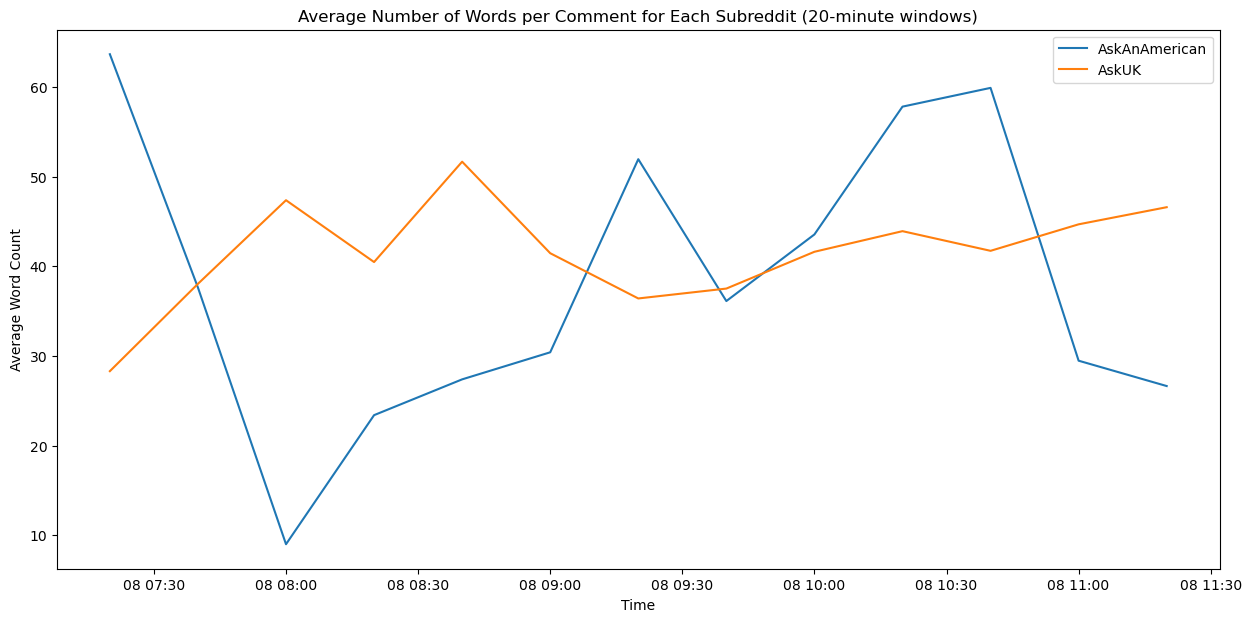

In [45]:
df = pd.read_csv('reddit_data.csv')

# Convert the 'created_utc' column to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Calculate the number of words in each comment
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

# Define a function to round the time to the previous 20-minute window
def round_time(dt, window_length):
    # Round the time down to the nearest window_length minutes
    new_minute = (dt.minute // window_length) * window_length
    return dt.replace(minute=new_minute, second=0, microsecond=0)

# Apply the rounding function to the 'created_utc' column
df['time_window'] = df['created_utc'].apply(lambda dt: round_time(dt, 20))

# Group by subreddit and time window, then calculate the average word count
grouped = df.groupby(['subreddit', 'time_window'])['word_count'].mean().reset_index()

# Pivot the table to have time windows as the index and subreddits as the columns
pivoted = grouped.pivot(index='time_window', columns='subreddit', values='word_count')

# Plot the results
plt.figure(figsize=(15, 7))
for subreddit in pivoted.columns:
    plt.plot(pivoted.index, pivoted[subreddit], label=subreddit)

plt.xlabel('Time')
plt.ylabel('Average Word Count')
plt.title('Average Number of Words per Comment for Each Subreddit (20-minute windows)')
plt.legend()
plt.show()


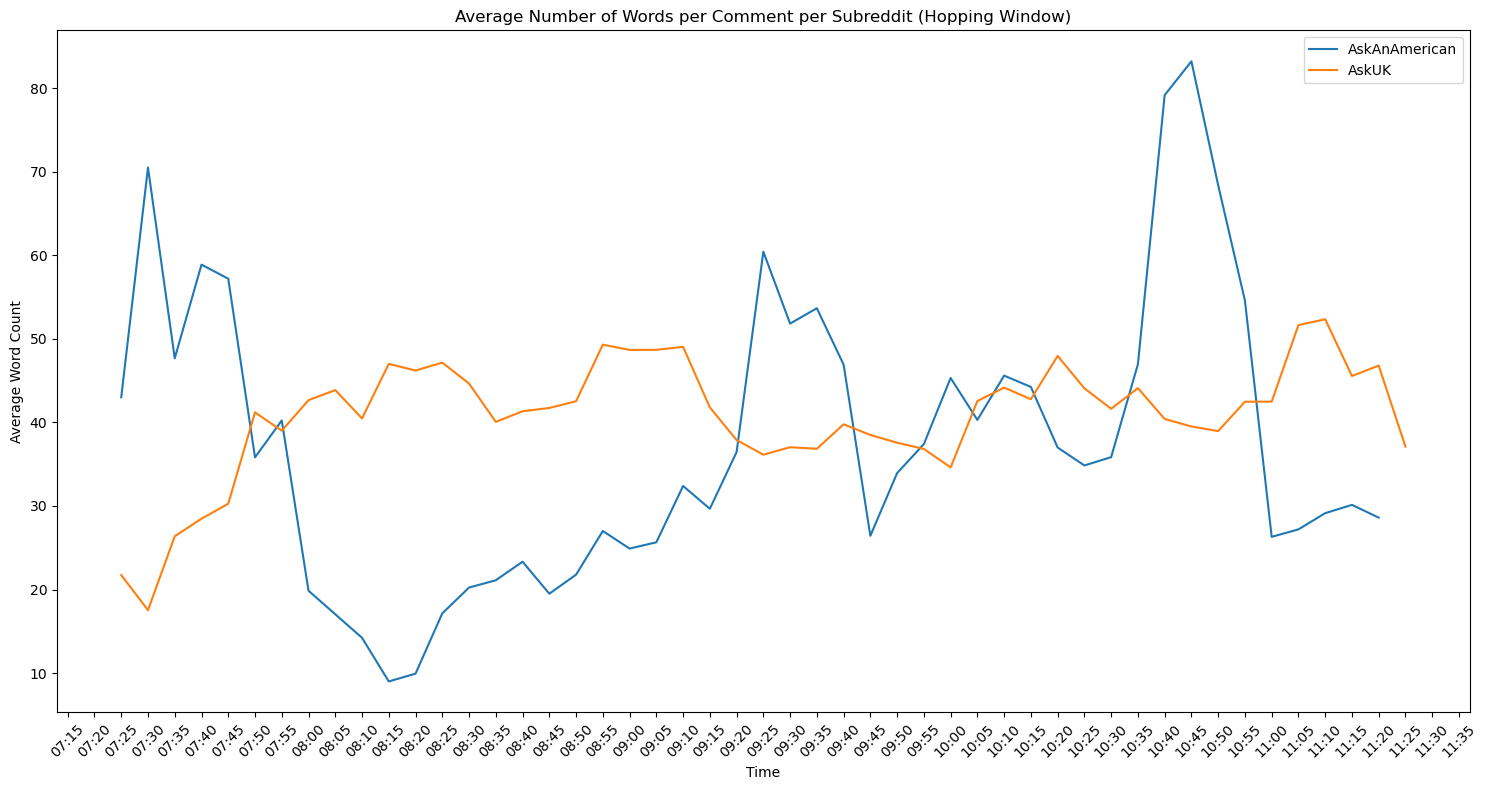

In [46]:
df = pd.read_csv('reddit_data.csv')

# Convert the 'created_utc' column to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define the hopping window parameters
window_length = '20T'  # 20 minutes window length
hop_size = '5T'  # 5 minutes hop size

# Create a new column for the hopping window start times
df['window_start'] = df['created_utc'].dt.floor(freq=hop_size)

# Create a column for the word count of each comment
df['word_count'] = df['body'].str.split().str.len()

# Calculate the average word count per subreddit per window start
avg_word_count = (df.groupby(['subreddit', 'window_start'])['word_count']
                    .mean()
                    .reset_index(name='avg_word_count'))

# Set the index to a datetime and then use `rolling` to aggregate these counts within each 20 minute window
avg_word_count.set_index('window_start', inplace=True)
avg_word_count.sort_index(inplace=True)

# Apply a rolling window, averaging the word counts from each 5 minute period to get the 20 minute window average
aggregated_averages = avg_word_count.groupby('subreddit')['avg_word_count'].rolling(window_length, min_periods=1).mean()
aggregated_averages = aggregated_averages.reset_index()

# Plotting
plt.figure(figsize=(15, 8))

for subreddit in aggregated_averages['subreddit'].unique():
    subset = aggregated_averages[aggregated_averages['subreddit'] == subreddit]
    plt.plot(subset['window_start'], subset['avg_word_count'], label=subreddit)

# Set the x-axis ticks to be every 5 minutes
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0, 60, 5)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.title('Average Number of Words per Comment per Subreddit (Hopping Window)')
plt.xlabel('Time')
plt.ylabel('Average Word Count')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



In [ ]:
"""The 20-minute window graph shows a more stable trend with less variation, suggesting an averaging out of extreme values,
while the hopping window graph displays greater variance and more pronounced peaks and troughs, offering a detailed view of fluctuating engagement.
"AskAnAmerican" demonstrates more variability than "AskUK" in the hopping window graph, indicating more variation in discussion lengths
or engagement levels during the sampled period."""